## Setup

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt

## Prepare the data

In [43]:
# loading all images
images = []
labels = []
root = './dataset/merged/'
for folder in os.listdir(root):
    for image in os.listdir(os.path.join(root, folder)):
        images.append(cv2.imread(os.path.join(root, folder, image)))
        labels.append(folder)

In [44]:
y_normal = pd.DataFrame(labels)
y_normal[0].unique()
y = pd.get_dummies(y_normal)
y.head()

,0_Bengin cases,0_Malignant cases,0_Normal cases
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


the dataset creation cell threw a warning aboout ragged sequences here, so i'm gonna detour here

In [45]:
# verify sizes of all images.
resolution = set()
count = 0
for image in images:
    if image.shape != (512, 512, 3):
        resolution.add(image.shape)
        count += 1
print(str(resolution) + '\n' + f"Number of irregular images: {count}")

{(512, 801, 3), (512, 623, 3), (404, 511, 3), (331, 506, 3)}
Number of irregular images: 61


#FIXTHIS 61 images have irregular resolutions. Removing them for now

In [46]:
filtimg = list()

for idx in range(len(images)):
    if images[idx].shape == (512, 512, 3):
        filtimg.append(images[idx])
    else:
        y.drop(idx, axis='rows', inplace=True)

if (len(images) - len(filtimg)) == 61:
    images = filtimg

In [47]:
dataset = np.array(images)

dataset.shape[0] == y.shape[0]

True

In [48]:
y.shape

(1036, 3)

In [49]:
num_classes = np.unique(y).shape[0]
input_shape = (512, 512, 3)

x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size = 0.25,
                                                    shuffle=True)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (777, 512, 512, 3) - y_train shape: (777, 3)
x_test shape: (259, 512, 512, 3) - y_test shape: (259, 3)


# Hyperparameter initialisation and Dataset finalization

In [50]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 25
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [51]:
# convert dataset into tensorflow `Dataset` objects
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = batch_size
IMG_SIZE = 56

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2023-07-19 17:43:55.642758: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 611057664 exceeds 10% of free system memory.
2023-07-19 17:43:57.923822: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 611057664 exceeds 10% of free system memory.
2023-07-19 17:43:58.631270: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 611057664 exceeds 10% of free system memory.


## Use data augmentation

In [52]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [53]:
# define cutmix augment
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)
    IMG_SIZE = 56

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two
    label1 = float(label1)
    label2 = float(label2)
    alpha = [0.25]
    beta = [0.25]
    IMG_SIZE = 56

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

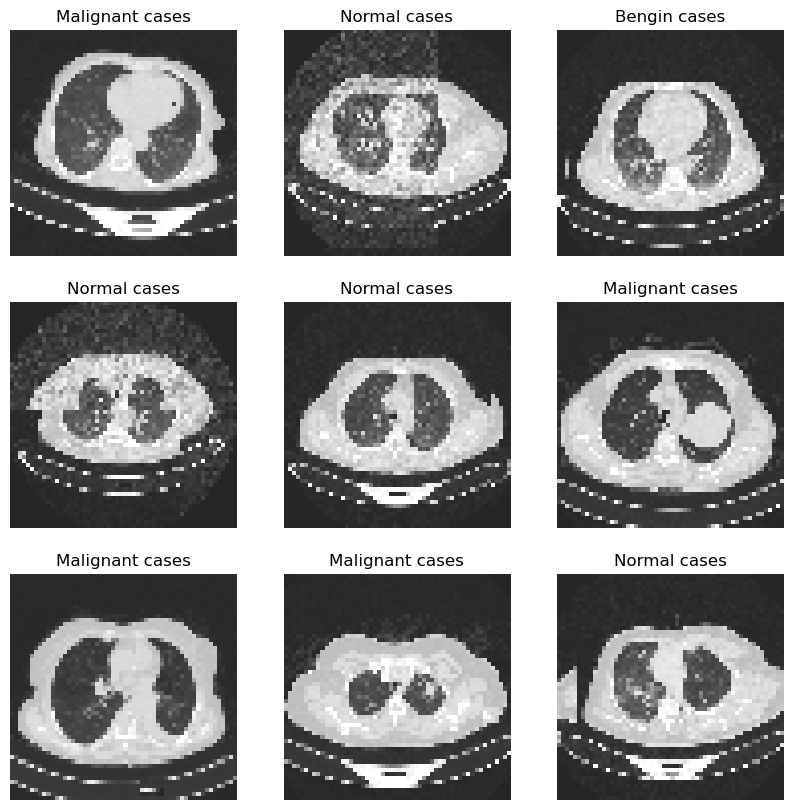

In [57]:
AUTO = tf.data.AUTOTUNE
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

class_names = os.listdir(root)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

## Implement multilayer perceptron (MLP)

In [58]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [59]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 56 X 56
Patch size: 6 X 6
Patches per image: 81
Elements per patch: 108


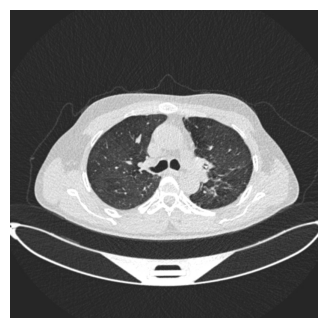

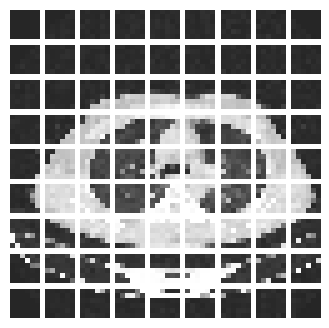

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [61]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [65]:

def create_vit_classifier():
    inputs = layers.Input(shape=(56, 56, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(3)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [66]:
model = create_vit_classifier()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 56, 56, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 56, 56, 3)            7         ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_2 (Patches)         (None, None, 108)            0         ['data_augmentation[1][0]']   
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 81, 64)               12160     ['patches_2[0][0]']     

In [68]:
# training and validation
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_cmu, epochs=150)

test_loss, test_accuracy = model.evaluate(train_ds_cmu)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/150
4/4 [==============================] - 21s 119ms/step - loss: 8.0936 - accuracy: 0.4170
Epoch 2/150
4/4 [==============================] - 1s 116ms/step - loss: 7.9627 - accuracy: 0.4054
Epoch 3/150
4/4 [==============================] - 1s 113ms/step - loss: 7.8533 - accuracy: 0.4157
Epoch 4/150
4/4 [==============================] - 1s 125ms/step - loss: 8.5341 - accuracy: 0.4028
Epoch 5/150
4/4 [==============================] - 1s 116ms/step - loss: 8.1524 - accuracy: 0.4041
Epoch 6/150
4/4 [==============================] - 1s 130ms/step - loss: 8.2438 - accuracy: 0.4093
Epoch 7/150
4/4 [==============================] - 1s 117ms/step - loss: 8.3134 - accuracy: 0.4106
Epoch 8/150
4/4 [==============================] - 1s 126ms/step - loss: 7.8135 - accuracy: 0.3977
Epoch 9/150
4/4 [==============================] - 1s 120ms/step - loss: 8.4671 - accuracy: 0.4157
Epoch 10/150
4/4 [==============================] - 1s 132ms/step - loss: 8.1714 - accuracy: 0.4311
Epoch 11

In [ ]:
# Put aside a few samples to create our validation set
x_val, y_val = x_train, y_train
new_x_train, new_y_train = x_train, y_train

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = int(images_one) * int(x_l) + int(images_two) * int((1 - x_l))
    labels = int(labels_one) * int(y_l) + int(labels_two) * int((1 - y_l))
    return (images, labels)

[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]


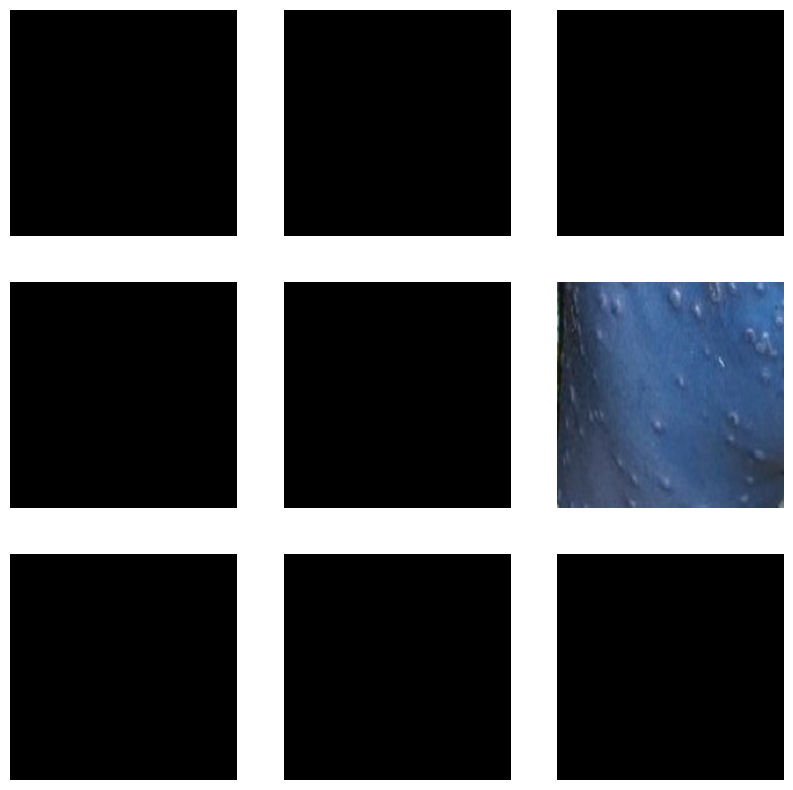

In [ ]:
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [ ]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(224, 224, 3)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(4, activation="softmax"),
        ]
    )
    return model

In [ ]:
model = get_training_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"], run_eagerly=True)
model.fit(train_ds_mu, epochs=1, batch_size=1)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))
model.summary()

1/1 [==============================] - 0s 60ms/step - loss: 18.3578 - accuracy: 0.2597
Test accuracy: 25.97%
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 dropout_178 (Dropout)       (None, 53, 53, 32)        0         
           

<_TakeDataset element_spec=(TensorSpec(shape=(None, 56, 56, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
1/1 [==============================] - 1s 634ms/step


ValueError: ignored

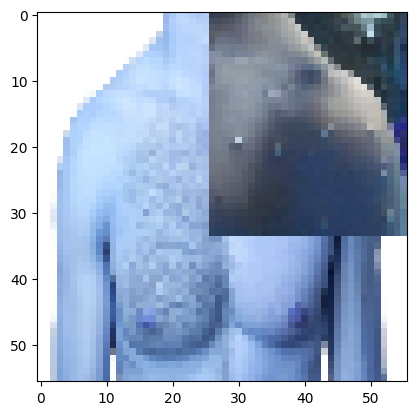

In [ ]:
layer_outputs=[layer.output for layer in model.layers]
img = train_ds_cmu.take(1)
print(img)

for output in layer_outputs[:3]:
    temp_model = tf.keras.Model(model.input, output)
    img = temp_model.predict(img)
    plt.imshow(img[0])